# Comparison with CEBRA

This notebook compares the decoding performance of MARBLE with CEBRA on a macaque centre-out reaching task. 

In [1]:
!pip install statannotations cebra ipympl

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import matplotlib.pyplot as plt
from cebra import CEBRA
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from statannotations.Annotator import Annotator
from sklearn.model_selection import KFold
from macaque_reaching_helpers import *
from tqdm import tqdm

## Let's train a CEBRA model first 

Load firing rate data

In [3]:
!wget -nc https://dataverse.harvard.edu/api/access/datafile/6969883 -O rate_data_20ms.pkl
!wget -nc https://dataverse.harvard.edu/api/access/datafile/6963200 -O trial_ids.pkl
    
rates, trial_ids = load_data("rate_data_20ms.pkl", "trial_ids.pkl")

File ‘rate_data_20ms.pkl’ already there; not retrieving.
File ‘trial_ids.pkl’ already there; not retrieving.


File ‘rate_data_20ms.pkl’ already there; not retrieving.
File ‘trial_ids.pkl’ already there; not retrieving.


# Load MARBLE and CEBRA embeddings

In [4]:
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7062022 -O marble_embeddings_20ms_out20.pkl
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7509031 -O cebra_embeddings_20ms_out20.pkl
!wget -nc https://dataverse.harvard.edu/api/access/datafile/6969885 -O kinematics.pkl

with open('marble_embeddings_20ms_out20.pkl', 'rb') as handle:
    _, marble_embeddings, _, _, trial_ids, _  = pickle.load(handle)

with open('cebra_embeddings_20ms_out20.pkl', 'rb') as handle:
    _, cebra_embeddings, _, _, _, _ = pickle.load(handle)

# load kinematic data
data = pickle.load(open('kinematics.pkl','rb'))       

# define conditions of movement
conditions=['DownLeft','Left','UpLeft','Up','UpRight','Right','DownRight']  

File ‘marble_embeddings_20ms_out20.pkl’ already there; not retrieving.
File ‘cebra_embeddings_20ms_out20.pkl’ already there; not retrieving.
File ‘kinematics.pkl’ already there; not retrieving.


# Load plain firing rates for comparison

In [5]:
data_file = "data/rate_data_20ms.pkl"
metadata_file = "data/trial_ids.pkl"
pca_n = 5
filter_data = True
    
rates, trials = load_data(data_file, metadata_file)

pos = []
for day in rates.keys():
    pca = fit_pca(rates, day, conditions, filter_data=filter_data, pca_n=pca_n)
    pos_, _, _, _, _ = format_data(rates, 
                                                                        trials,
                                                                        day, 
                                                                        conditions, 
                                                                        pca=pca,
                                                                        filter_data=filter_data,
                                                                       )
    pos.append(np.vstack(pos_))

File ‘data/rate_data_20ms.pkl’ already there; not retrieving.
File ‘data/trial_ids.pkl’ already there; not retrieving.


In [6]:
# use the saved trial ids to match the embeddings to the kinematics

for d in list(data.keys()):
    unique_trial_ids = np.unique(trial_ids[d])
    for t in unique_trial_ids:
        data[d][t]['kinematics'] = data[d][t]['kinematics'][:,:-1] #remove last point because
        data[d][t]['lfads_factors'] = data[d][t]['lfads_factors'][:,:-1] 
        data[d][t]['marble_emb'] = marble_embeddings[d][trial_ids[d]==t,:].T
        data[d][t]['firing_rates'] = pos[d][trial_ids[d]==t,:].T
        data[d][t]['cebra_emb'] = cebra_embeddings[d][trial_ids[d]==t,:].T

# Visualise kinematics for a single session

Text(0.5, 1.0, 'per trial kinematic hand position')

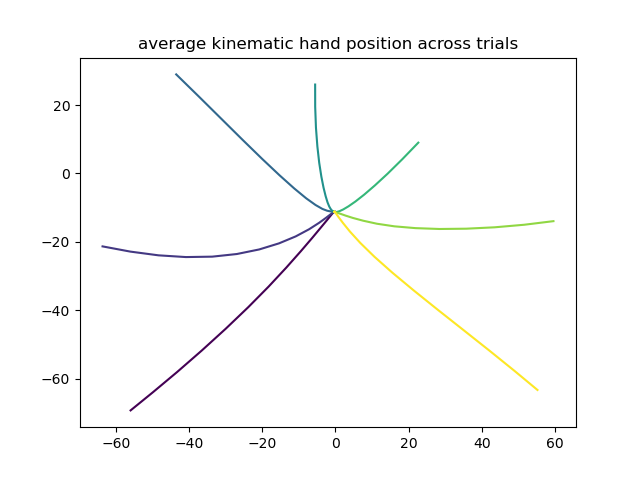

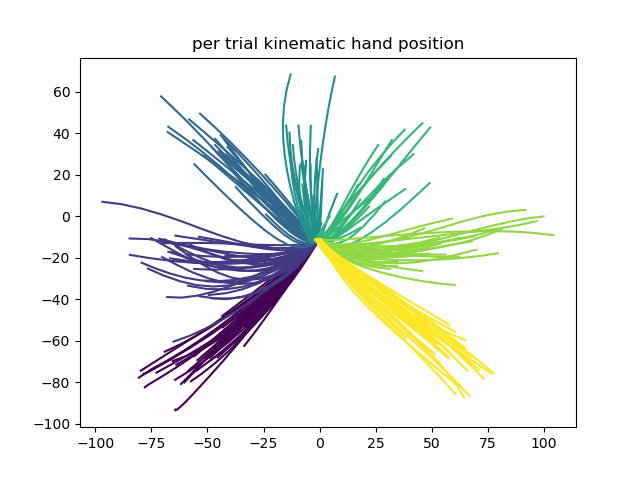

In [7]:
session = 0

colors = plt.cm.viridis(np.linspace(0,1,7))

# plot average kinematic position across trials for a given session
plt.figure()
for c,cond in enumerate(conditions):   
    meh = np.dstack([data[session][t]['kinematics'] for t in data[session].keys() if data[session][t]['condition']==cond]).mean(2)        
    plt.plot(meh[0,:],meh[1,:],c=colors[c])
plt.title('average kinematic hand position across trials')

# plot kinematic position for each trials in a given session
plt.figure()
for c,cond in enumerate(conditions):   
    for t in data[session].keys():
        if data[session][t]['condition']==cond:
            meh = data[session][t]['kinematics']
            plt.plot(meh[0,:],meh[1,:],c=colors[c])
plt.title('per trial kinematic hand position')

# Decoding single session

### Optimal linear decoding via LFADS, MARBLE and CEBRA

In [8]:
session = 0

unique_trial_ids = np.unique(trial_ids[session])

L_lfads = train_OLE(data[session], trial_ids[session], representation='lfads_factors')

# loop over test trials
for tr in unique_trial_ids:
    trial_pred = decode_kinematics(data[session][tr], L_lfads, dt=20, representation='lfads_factors')
    data[session][tr]['lfads_decoded'] = trial_pred

L_firing_rates = train_OLE(data[session], trial_ids[session], representation='firing_rates')

# loop over test trials
for tr in unique_trial_ids:
    trial_pred = decode_kinematics(data[session][tr], L_firing_rates, dt=20, representation='firing_rates')
    data[session][tr]['firing_rates_decoded'] = trial_pred

L_marble = train_OLE(data[session], trial_ids[session], representation='marble_emb')

# loop over test trials
for tr in unique_trial_ids:
    trial_pred = decode_kinematics(data[session][tr], L_marble, dt=20, representation='marble_emb')
    data[session][tr]['marble_decoded'] = trial_pred
    
L_cebra = train_OLE(data[session], trial_ids[session], representation='cebra_emb')

# loop over test trials
for tr in unique_trial_ids:
    trial_pred = decode_kinematics(data[session][tr], L_cebra, dt=20, representation='cebra_emb')
    data[session][tr]['cebra_decoded'] = trial_pred

### Comparison of decoding with ground truth

<AxesSubplot:title={'center':'cebra_decoded'}>

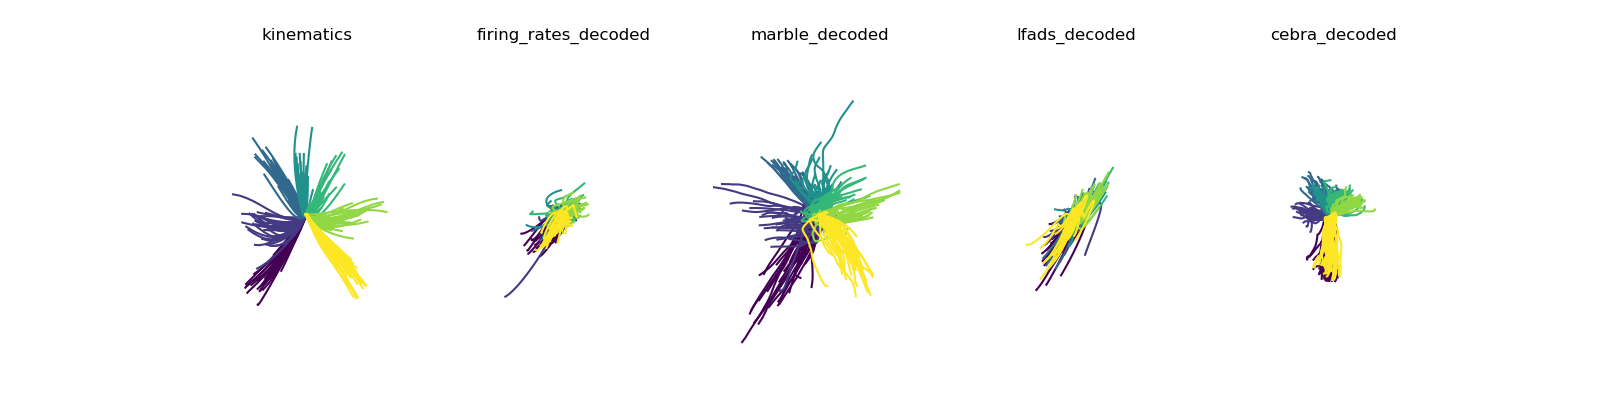

In [9]:
fig, ax = plt.subplots(1,5,figsize=(16,4))

plot_kinematics(data, session, unique_trial_ids, representation='kinematics', ax=ax[0])
plot_kinematics(data, session, unique_trial_ids, representation='firing_rates_decoded', ax=ax[1])
plot_kinematics(data, session, unique_trial_ids, representation='marble_decoded', ax=ax[2])
plot_kinematics(data, session, unique_trial_ids, representation='lfads_decoded', ax=ax[3])
plot_kinematics(data, session, unique_trial_ids, representation='cebra_decoded', ax=ax[4])

# Decode across all sessions

Above we decoded for a single session. Lets now loop over every session and compute some quantitative comparisons with the ground truth kinematics.

In [10]:
kf = KFold(n_splits=5, shuffle=True) # use 5-fold split of the data 

r2_lfads_vel = []; r2_lfads_pos = []
r2_cebra_vel = []; r2_cebra_pos = []
r2_marble_vel = []; r2_marble_pos = []
r2_firing_rates_vel = []; r2_firing_rates_pos = []

# loop over seessions
for d in tqdm(data.keys()):
    unique_trial_ids = np.unique(trial_ids[d])
    
    # cross validation
    for i, (train_index, test_index) in enumerate(kf.split(unique_trial_ids)):

        train_data = {key: data[d][key] for key in train_index if key in data[d]}

        #LFADS
        Lw = train_OLE(data[d], unique_trial_ids[train_index], representation='lfads_factors')
        
        for tr in unique_trial_ids[test_index]:
            trial_pred = decode_kinematics(data[d][tr], Lw, dt=20, representation='lfads_factors')
            data[d][tr]['lfads_decoded'] = trial_pred
           
        #CEBRA
        Lw = train_OLE(data[d], unique_trial_ids[train_index], representation='cebra_emb')
        
        for tr in unique_trial_ids[test_index]:
            trial_pred = decode_kinematics(data[d][tr], Lw, dt=20, representation='cebra_emb')
            data[d][tr]['cebra_decoded'] = trial_pred
            
        #MARBLE
        Lw = train_OLE(data[d], unique_trial_ids[train_index], representation='marble_emb')
        
        for tr in unique_trial_ids[test_index]:
            trial_pred = decode_kinematics(data[d][tr], Lw, dt=20, representation='marble_emb')
            data[d][tr]['marble_decoded'] = trial_pred


        #Firing rates
        Lw = train_OLE(data[d], unique_trial_ids[train_index], representation='firing_rates')
        
        for tr in unique_trial_ids[test_index]:
            trial_pred = decode_kinematics(data[d][tr], Lw, dt=20, representation='firing_rates')
            data[d][tr]['firing_rates_decoded'] = trial_pred
            
    # r-squared velocity
    r2_pos, r2_vel = correlation(data[d], unique_trial_ids, representation='lfads_decoded')   
    r2_lfads_pos.append(r2_pos)
    r2_lfads_vel.append(r2_vel)
    
    r2_pos, r2_vel = correlation(data[d], unique_trial_ids, representation='cebra_decoded')   
    r2_cebra_pos.append(r2_pos)
    r2_cebra_vel.append(r2_vel)
    
    r2_pos, r2_vel = correlation(data[d], unique_trial_ids, representation='marble_decoded')   
    r2_marble_pos.append(r2_pos)
    r2_marble_vel.append(r2_vel)

    r2_pos, r2_vel = correlation(data[d], unique_trial_ids, representation='firing_rates_decoded')   
    r2_firing_rates_pos.append(r2_pos)
    r2_firing_rates_vel.append(r2_vel)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:52<00:00,  1.19s/it]


Lets now visualise the decoded kinematics for the same set of example sessions (Fig S7).

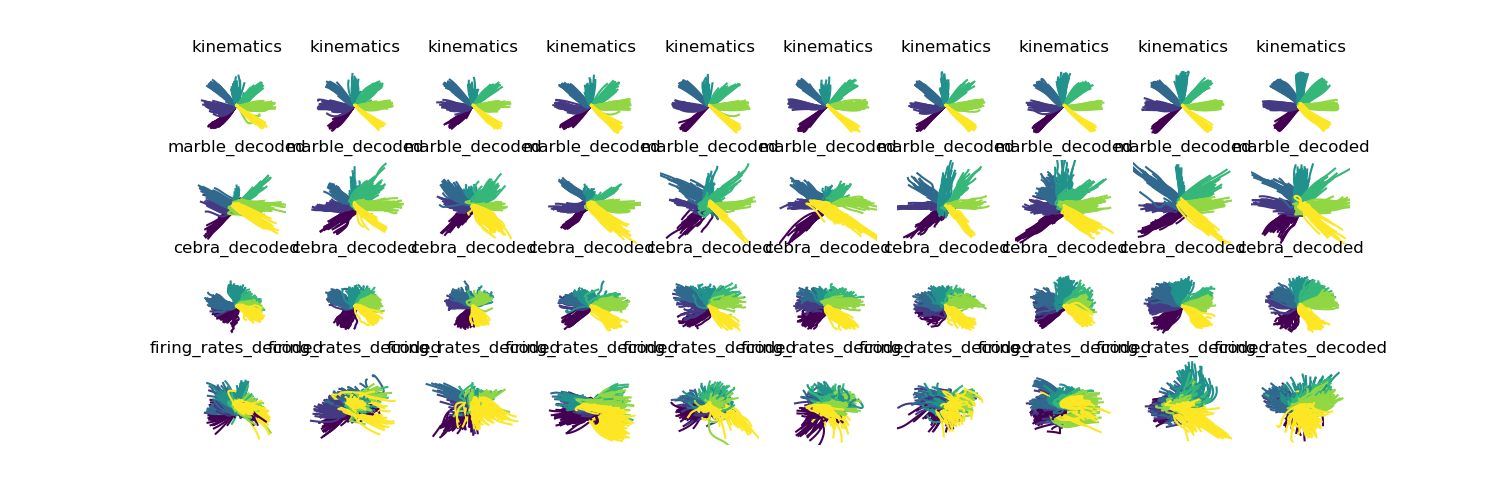

In [11]:
# chosen example sessions
examples = [5,6,8,11,14,15,18,23,26,32]

fig, ax = plt.subplots(4,len(examples),figsize=(15,5))

for i,d in enumerate(examples):
    
    unique_trial_ids = np.unique(trial_ids[d])

    ax[0,i] = plot_kinematics(data, d, unique_trial_ids, representation='kinematics', ax=ax[0,i])
    ax[1,i] = plot_kinematics(data, d, unique_trial_ids, representation='marble_decoded', ax=ax[1,i])
    ax[2,i] = plot_kinematics(data, d, unique_trial_ids, representation='cebra_decoded', ax=ax[2,i])
    ax[3,i] = plot_kinematics(data, d, unique_trial_ids, representation='lfads_decoded', ax=ax[3,i])
    ax[3,i] = plot_kinematics(data, d, unique_trial_ids, representation='firing_rates_decoded', ax=ax[3,i])

How does the decoding accuracy of velocity between the two methods compare?

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

marble vs. CEBRA: Wilcoxon test (paired samples), P_val:1.137e-13 Stat=0.000e+00
marble vs. LFADS: Wilcoxon test (paired samples), P_val:1.033e-03 Stat=2.210e+02
marble vs. firing_rates: Wilcoxon test (paired samples), P_val:1.137e-13 Stat=0.000e+00


/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


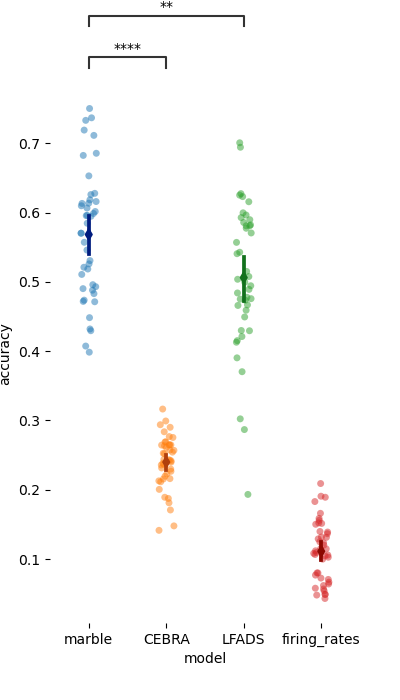

In [16]:
results = pd.DataFrame(data=np.vstack([ r2_marble_vel, r2_cebra_vel, r2_lfads_vel, r2_firing_rates_vel]).T,columns=['marble', 'CEBRA', 'LFADS', 'firing_rates'])
results = results.melt()
results.columns = ['model','accuracy']

f, ax = plt.subplots(figsize=(4,7))
sns.despine(bottom=True, left=True)

sns.stripplot(
    data=results, x="model", y="accuracy",
    dodge=True, alpha=.5, zorder=1,
)

sns.pointplot(
    data=results, x="model", y="accuracy",
    join=False, dodge=.8 - .8 / 3, palette="dark",
    markers="d", scale=.75, errorbar=None
)

pairs=[("LFADS", "marble"), ("CEBRA","marble"), ("firing_rates","marble")]

annotator = Annotator(ax, pairs, data=results, x="model", y="accuracy",)
annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
annotator.apply_and_annotate()

Can we train a classifier to predict the movement? This tells us about the accuracy of decoding the position vectors.

In [13]:
conditions=['DownLeft','Left','UpLeft','Up','UpRight','Right','DownRight']  
marble_model_acc = []
cebra_model_acc = []
lfads_model_acc = []
firing_rates_model_acc = []

for d in tqdm(data.keys()):           

    unique_trial_ids = np.unique(trial_ids[d])
    
    # fit classifier to kinematics
    clf = fit_classifier(data[d], conditions, unique_trial_ids, representation='kinematics')
    
    # evaluate classifier on marble decoded
    score = transform_classifier(clf, data[d], conditions, unique_trial_ids, representation='marble_decoded')
    marble_model_acc.append(score)
    
    # evaluate classifier on cebra decoded
    score = transform_classifier(clf, data[d], conditions, unique_trial_ids, representation='cebra_decoded')
    cebra_model_acc.append(score)
    
    # evaluate classifier on lfads decoded
    score = transform_classifier(clf, data[d], conditions, unique_trial_ids, representation='lfads_decoded')
    lfads_model_acc.append(score)

    # evaluate classifier on firing_rates
    score = transform_classifier(clf, data[d], conditions, unique_trial_ids, representation='firing_rates_decoded')
    firing_rates_model_acc.append(score)

results = pd.DataFrame(data=np.vstack([ marble_model_acc, cebra_model_acc, lfads_model_acc, firing_rates_model_acc]).T,columns=['marble', 'cebra', 'LFADS', 'firing_rates'])

results = results.melt()
results.columns = ['model','accuracy']

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 38.03it/s]


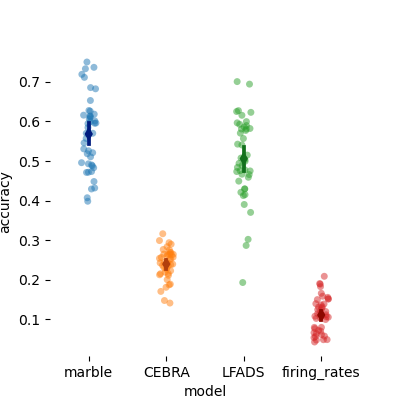

In [17]:
f, ax = plt.subplots(figsize=(4,4))
sns.despine(bottom=True, left=True)

sns.stripplot(
    data=results, x="model", y="accuracy",
    dodge=True, alpha=.5, zorder=1,
)

sns.pointplot(
    data=results, x="model", y="accuracy",
    join=False, dodge=.8 - .8 / 3, palette="dark",
    markers="d", scale=.75, errorbar=None
)